# Reference

This code is copied from the [hugging face translation tutorial](https://huggingface.co/docs/transformers/en/tasks/translation) 

In [1]:
import torch
from tqdm.notebook import trange, tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import evaluate
import json
import numpy as np
from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import AutoTokenizer
from transformers import DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import T5ForConditionalGeneration, T5TokenizerFast, GenerationConfig

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [2]:
books = load_dataset("opus_books", "en-fr")

In [3]:
books = books["train"].train_test_split(test_size=0.2, seed=42)

In [4]:
books["train"][0:3]["translation"]

[{'en': 'What a stroke was this for poor Jane! who would willingly have gone through the world without believing that so much wickedness existed in the whole race of mankind, as was here collected in one individual.',
  'fr': 'Quel coup pour la pauvre Jane qui aurait parcouru le monde entier sans s’imaginer qu’il existât dans toute l’humanité autant de noirceur qu’elle en découvrait en ce moment dans un seul homme !'},
 {'en': "The ground rose appreciably as it moved away from the sand flats by the waves, and we soon arrived at some long, winding gradients, genuinely steep paths that allowed us to climb little by little; but we had to tread cautiously in the midst of pudding stones that weren't cemented together, and our feet kept skidding on glassy trachyte, made of feldspar and quartz crystals.",
  'fr': "Le sol s'élevait sensiblement en s'éloignant du relais des flots, et nous Mmes bientôt arrivés à des rampes longues et sinueuses, véritables raidillons qui permettaient de s'élever 

In [5]:
checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [6]:
def preprocess_function_en_to_fr(examples):
    source_lang = "en"
    target_lang = "fr"
    prefix = "translate English to French: "

    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

def preprocess_function_fr_to_en(examples):
    source_lang = "fr"
    target_lang = "en"
    prefix = "translate French to English: "
    
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [7]:
books["train"]

Dataset({
    features: ['id', 'translation'],
    num_rows: 101668
})

In [8]:
tokenized_books_en_to_fr = books.map(preprocess_function_en_to_fr, batched=True)
tokenized_books_fr_to_en = books.map(preprocess_function_fr_to_en, batched=True)

In [9]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [10]:
metric = evaluate.load("sacrebleu")

In [11]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    
    preds = np.where(preds < 0, tokenizer.pad_token_id, preds)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result



In [12]:
def finetune_model(local_model, name: str, num_epochs: int, tokenized_dataset, max_len=32):
    local_training_args = Seq2SeqTrainingArguments(
        output_dir=name,
        eval_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        generation_max_length=max_len, # can reduce this for faster training, but worse preformance (min = 20)
        weight_decay=0.01,
        save_total_limit=3,
        num_train_epochs=num_epochs,
        predict_with_generate=True,
        fp16=True, #change to bf16=True for XPU
        push_to_hub=False,
    )

    local_trainer = Seq2SeqTrainer(
        model=local_model,
        args=local_training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    local_trainer.train()

# Inference

In [ ]:
# model = T5ForConditionalGeneration.from_pretrained("my_awesome_opus_books_model/checkpoint-12710/").to(device)

In [ ]:
# text = "translate English to French: Legumes share resources with nitrogen-fixing bacteria."
# inputs = tokenizer(text, return_tensors="pt").input_ids.to(device)

In [ ]:
# outputs = model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)
# tokenizer.decode(outputs[0], skip_special_tokens=True)


# Create base French to English Model

In [ ]:
checkpoint = "google-t5/t5-small"

model_fr_to_en = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [ ]:
finetune_model(model_fr_to_en, "t5_fr_to_en_final", 2, tokenized_books_fr_to_en)
torch.cuda.empty_cache()

# Create base English to French Model

In [ ]:
checkpoint = "google-t5/t5-small"

model_en_to_fr = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [ ]:
finetune_model(model_en_to_fr, "t5_en_to_fr", 1, tokenized_books_en_to_fr)
torch.cuda.empty_cache()

# Load nessessary models

In [13]:
en_to_fr_checkpoint = "checkpoint-6355"

model_en_to_fr = T5ForConditionalGeneration.from_pretrained(f"t5_en_to_fr/{en_to_fr_checkpoint}/").to(device)

fr_to_en_checkpoint = "checkpoint-12710"

model_fr_to_en = T5ForConditionalGeneration.from_pretrained(f"t5_fr_to_en_final/{fr_to_en_checkpoint}/").to(device)

# Building Recursive Train Loop

### Create Smaller Test and Train Datasets 

In [69]:
np.random.seed(42)

In [70]:
test_dataset_len = tokenized_books_en_to_fr["test"].num_rows
test_smaller_size = 2500

test_dataset_indicies = np.arange(test_dataset_len)
np.random.shuffle(test_dataset_indicies)

start_indicies = test_dataset_indicies[:test_smaller_size]

reduced_tokenized_test = tokenized_books_en_to_fr["test"].select(start_indicies)

# need to do this to prevent random errors ¯\_(ツ)_/¯
test_tokenized_dataset = reduced_tokenized_test.remove_columns(books["test"].column_names)
complete_test_dataset = tokenized_books_en_to_fr["test"].remove_columns(books["test"].column_names)

In [71]:
np.random.seed(84)

In [72]:
train_dataset_len = tokenized_books_en_to_fr["train"].num_rows
train_smaller_size = 10000 # 10,000

train_dataset_indicies = np.arange(train_dataset_len)
np.random.shuffle(train_dataset_indicies)

start_indicies = train_dataset_indicies[:train_smaller_size]

reduced_tokenized_train = tokenized_books_en_to_fr["train"].select(start_indicies)

# need to do this to prevent random errors ¯\_(ツ)_/¯
train_tokenized_dataset = reduced_tokenized_train.remove_columns(books["train"].column_names)
complete_train_dataset = tokenized_books_en_to_fr["train"].remove_columns(books["train"].column_names)

### One Recursive Train loop

In [74]:
def get_recursive_data(train_dataset, model_forward = model_en_to_fr, model_reverse = model_fr_to_en, batch_size = 512):
    torch.cuda.empty_cache()

    dataset_list = []
    english_sentences = []
    french_sentences = []

    loader = DataLoader(train_dataset, batch_size = batch_size, collate_fn = data_collator)

    for i, tokenized_inputs in tqdm(enumerate(loader), total=len(loader), desc = "Forward (EN to FR) Inference Pass"):
        with torch.no_grad():
            generated_outputs = model_forward.generate(
                input_ids=tokenized_inputs['input_ids'].to(device),
                attention_mask=tokenized_inputs['attention_mask'].to(device),
                max_length=128,  # Maximum length for generation
                num_return_sequences=1  # Number of sequences to return per input
            ).cpu()

        decoded = tokenizer.batch_decode(generated_outputs, skip_special_tokens=True)
        french_sentences.extend(decoded)
        decoded = list(map(lambda s: "translate French to English: " + s, decoded))

        encoded = tokenizer(decoded, return_tensors="pt", max_length=128, padding=True, truncation=True)
        dataset_list.append(Dataset.from_dict(encoded))

        del generated_outputs, tokenized_inputs
        torch.cuda.empty_cache()

    reverse_dataset = concatenate_datasets(dataset_list)

    loader2 = DataLoader(reverse_dataset, batch_size = batch_size, collate_fn = data_collator)

    for i, tokenized_inputs in tqdm(enumerate(loader2), total=len(loader2), desc = "Reverse (FR to EN) Inference Pass"):
        with torch.no_grad():
            generated_outputs = model_reverse.generate(
                input_ids=tokenized_inputs['input_ids'].to(device),
                attention_mask=tokenized_inputs['attention_mask'].to(device),
                max_length=128,  # Maximum length for generation
                num_return_sequences=1  # Number of sequences to return per input
            ).cpu()
        decoded = tokenizer.batch_decode(generated_outputs, skip_special_tokens=True)
        english_sentences.extend(decoded)

        del generated_outputs, tokenized_inputs
        torch.cuda.empty_cache()

    synthetic_data = {"translation": []}

    for eng, fr in zip(english_sentences, french_sentences):
        elem = {"en": eng, "fr": fr}
        synthetic_data["translation"].append(elem)

    test_syn_en_to_fr_dataset = Dataset.from_dict(synthetic_data)
    test_syn_en_to_fr_dataset = test_syn_en_to_fr_dataset.map(preprocess_function_en_to_fr, batched=True)
    test_syn_en_to_fr_dataset = test_syn_en_to_fr_dataset.remove_columns("translation")

    return test_syn_en_to_fr_dataset

# new_syn_dataset = get_recursive_data(train_tokenized_dataset)

### Train Model for Recursive Loop

In [75]:
def rec_finetune_model(local_model, name: str, num_epochs: int, train_data, test_data):
    local_training_args = Seq2SeqTrainingArguments(
        output_dir=name,
        eval_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        generation_max_length=32,
        weight_decay=0.01,
        save_total_limit=3,
        num_train_epochs=num_epochs,
        predict_with_generate=True,
        fp16=True, #change to bf16=True for XPU
        push_to_hub=False,
    )

    local_trainer = Seq2SeqTrainer(
        model=local_model,
        args=local_training_args,
        train_dataset=train_data,
        eval_dataset=test_data,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    local_trainer.train()

    torch.cuda.empty_cache()

### Validation Loop To Get Bleu Score

In [76]:
def eval_loop(local_model, test_data, output_dir = "temp_results", batch_size = 16, max_len = 64):

    test_training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        per_device_eval_batch_size=batch_size,
        generation_max_length=max_len,
        save_total_limit=3,
        predict_with_generate=True,
        fp16=True, #change to bf16=True for XPU
        push_to_hub=False,
    )

    test_trainer = Seq2SeqTrainer(
        model=local_model,
        args=test_training_args,
        eval_dataset=test_data,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    eval_results = test_trainer.evaluate()

    torch.cuda.empty_cache()

    return eval_results

### Recursive Train Loop

In [79]:
def recursive_train(model, validate_model, train_data, test_data, num_iters, augmentation_ratio = 0.0, train_size = train_smaller_size):
    blue_score = []
    all_scores = []

    real_num_indicies = int(augmentation_ratio * len(train_data))
    syn_data_num_indicies = len(train_data) - real_num_indicies

    validate_model.eval()

    local_train_data = train_data

    for i in range(num_iters):
        torch.cuda.empty_cache()
        print(f"\nIteration {i + 1}/{num_iters}")

        rec_finetune_model(model, f"test_model{i+1}", 1, local_train_data, test_data)

        torch.cuda.empty_cache()

        if real_num_indicies != 0:
            # reduce the size of the train data to let us add the real data later
            
            random_indices = np.random.choice(len(local_train_data), syn_data_num_indicies, replace=False)
            local_train_data = local_train_data.select(random_indices)

        synn_data = get_recursive_data(local_train_data, model, validate_model, batch_size=256)

        torch.cuda.empty_cache()

        if real_num_indicies != 0:
            # get the next real_num_indicies of actual data to add to the train data
            start_idx = train_size + int((i * real_num_indicies))
            end_idx = train_size + int(((i+1) * real_num_indicies))

            # train_dataset_indicies is a list of all the indicies in train data (~125000 elems)
            # with all the indicies shuffeled
            indicies_to_add = train_dataset_indicies[start_idx:end_idx]

            real_data = complete_train_dataset.select(indicies_to_add)

            local_train_data = concatenate_datasets([real_data, synn_data])
        else:
            local_train_data = synn_data

        eval_metrics = eval_loop(model, test_data)

        blue_score.append(eval_metrics["eval_bleu"])
        all_scores.append(eval_metrics)
    
    return blue_score, all_scores
        

# Run Recursive Training

In [ ]:
recursive_train(model_en_to_fr, model_fr_to_en, train_tokenized_dataset, test_tokenized_dataset, 2, augmentation_ratio=0.2)

### Ideal Ratio Experiments

In [ ]:
def test_ratios(model_file, validate_model_file, train_data, test_data, num_iters, ratios_list):
  data = {}

  for ratio in ratios_list:
    print(f"------------ Testing Ratio: {round(ratio, 2)} ------------")

    model = T5ForConditionalGeneration.from_pretrained(f"t5_en_to_fr/{model_file}/").to(device)
    validate_model = T5ForConditionalGeneration.from_pretrained(f"t5_fr_to_en_final/{validate_model_file}/").to(device)

    name = "Ratio_" + str(round(ratio, 2))

    blue_score, all_scores = recursive_train(model, validate_model, train_data, test_data, num_iters, augmentation_ratio = ratio)
    data[name] = (blue_score, all_scores)

    torch.cuda.empty_cache()

  return data


In [ ]:
ratio_list = [0.1, 0.2, 0.3, 0.4, 0.5]

data = test_ratios("checkpoint-6355", "checkpoint-12710", train_tokenized_dataset, test_tokenized_dataset, 4, ratio_list)

with open('ratio_experiments.txt', 'w') as convert_file:
     convert_file.write(json.dumps(data))

data

# Plotting

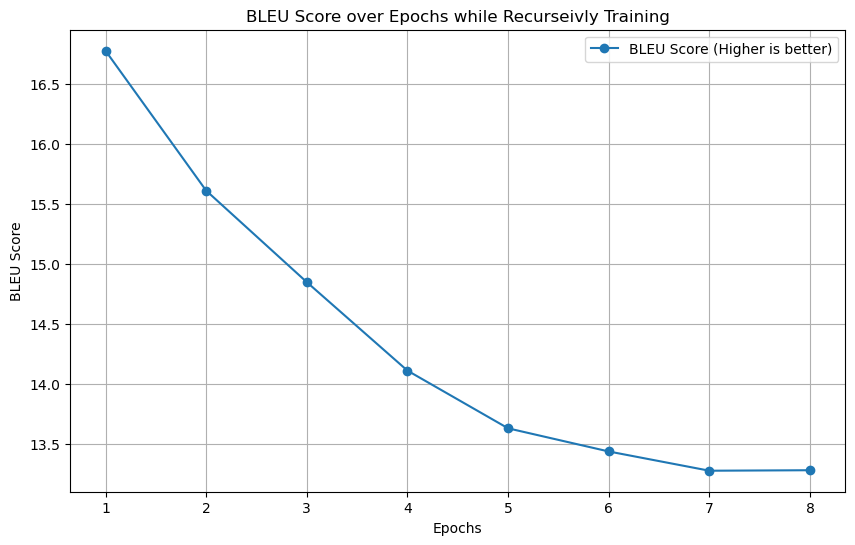

In [21]:
bleu_scores  = [16.7773, 15.6103, 14.8468, 14.1085, 13.6272, 13.4341, 13.2735, 13.2776]
epochs = range(1, len(bleu_scores) + 1)  # Create a list of epoch numbers

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size
plt.plot(epochs, bleu_scores, marker='o', linestyle='-', label="BLEU Score (Higher is better)")
plt.xlabel("Epochs")
plt.ylabel("BLEU Score")
plt.title("BLEU Score over Epochs while Recurseivly Training")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import json

# Load the dictionary from the file
with open("ratio_experiments.txt", "r") as file:
    data = json.load(file)

# 'data' is now your dictionary

dict_keys(['Ratio_0.1', 'Ratio_0.2', 'Ratio_0.3', 'Ratio_0.4', 'Ratio_0.5'])
[[16.7773, 15.9144, 15.4741, 14.9116], [{'eval_loss': 1.6717504262924194, 'eval_model_preparation_time': 0.004, 'eval_bleu': 16.7773, 'eval_gen_len': 37.8316, 'eval_runtime': 136.0012, 'eval_samples_per_second': 18.382, 'eval_steps_per_second': 1.154}, {'eval_loss': 1.727998971939087, 'eval_model_preparation_time': 0.0033, 'eval_bleu': 15.9144, 'eval_gen_len': 39.2184, 'eval_runtime': 140.2354, 'eval_samples_per_second': 17.827, 'eval_steps_per_second': 1.12}, {'eval_loss': 1.7987828254699707, 'eval_model_preparation_time': 0.0035, 'eval_bleu': 15.4741, 'eval_gen_len': 39.7336, 'eval_runtime': 142.628, 'eval_samples_per_second': 17.528, 'eval_steps_per_second': 1.101}, {'eval_loss': 1.8369568586349487, 'eval_model_preparation_time': 0.0035, 'eval_bleu': 14.9116, 'eval_gen_len': 40.0848, 'eval_runtime': 144.6451, 'eval_samples_per_second': 17.284, 'eval_steps_per_second': 1.085}]]


In [36]:
ratio_name_list = data.keys()

all_ratio_bleu_data = [[16.7773, 15.6103, 14.8468, 14.1085]]

for key in data:
    all_ratio_bleu_data.append(data[key][0])

all_ratio_bleu_data = np.array(all_ratio_bleu_data)

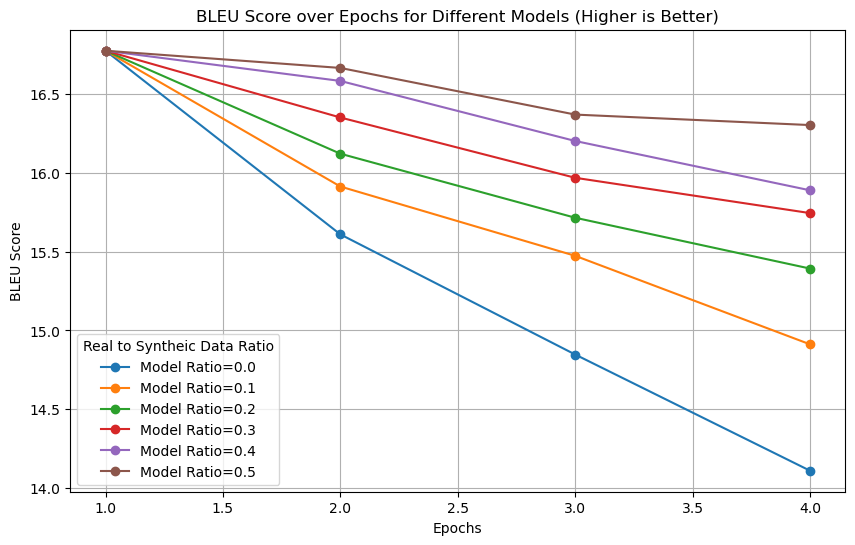

In [43]:
epochs = range(1, len(all_ratio_bleu_data[0]) + 1)  # Epoch numbers

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size

ratio_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Loop over each model's BLEU scores
for i, model_scores in enumerate(all_ratio_bleu_data, start=1):
    plt.plot(epochs, model_scores, marker='o', linestyle='-', label=f"Model Ratio={ratio_list[i-1]}")

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("BLEU Score")
plt.title("BLEU Score over Epochs for Different Models (Higher is Better)")
plt.legend(title="Real to Syntheic Data Ratio")
plt.grid(True)

# Show the plot
plt.savefig("BLEU_score_dif_ratio.png")
plt.show()